<a href="https://colab.research.google.com/github/ymuto0302/PJ2024/blob/main/GIS3_5_real_market_area_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 地理情報の活用(3-5)：現実の店舗および人口分布を対象とした商圏人口の推定
前回は，仮想的な店舗・居住地・人口をデータとして用いた商圏人口推定を取り上げた。

本ノートブックでは，
現実の「山口県の人口データ」および現実の「店舗データ」を用いた商圏人口推定の方法論を取り上げる。

---
## (準備) rtree および GeoPandas のインストール
GeoPandas の空間結合(spatial join) `sjoin()` を利用するため，ライブラリ "rtree" が必要となる。

GeoPandas との整合性の関係から，rtree や shapely のインストール後に GeoPandas をインストールする。

In [1]:
!pip install pandas fiona shapely pyproj rtree
!pip install geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.2/535.2 kB 2.6 MB/s eta 0:00:00


## (準備) Google Drive のマウント

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
## (復習) 山口県の人口データの取得
(注) これは「地理情報の活用(2)：人口密度分布の可視化」にて取り上げた内容である。

「地図で見る統計(統計GIS)」 https://www.e-stat.go.jp/gis から国勢調査の結果を取得する。このデータには，例えば「宇部市若松町１丁目に○○人の人口がある」といった情報が含まれる。

以下では，国勢調査のデータがシェイプファイル "r2ka35.shp" に格納されていることを前提とする。

In [3]:
import geopandas as gpd

# 地理情報データの読み込み
yamaguchi = gpd.read_file(r'/content/drive/My Drive/BASE/GeoData/e-stat/Yamaguchi/r2ka35.shp')

# 水面調査区の除去
yamaguchi = yamaguchi[yamaguchi['HCODE'] != 8154]

### (参考)CRSの確認およびデータの中身を確認
- 変数 `yamaguchi' の CRS を確認すると，座標系として緯度・経度が利用されている。("Axis Info" の値を参照）
- 変数 "yamaguchi" には町名・丁名，面積，人口など，多様なデータが格納されている。

In [4]:
# CRS の確認
yamaguchi.crs

<Geographic 2D CRS: EPSG:4612>
Name: JGD2000
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Japan - onshore and offshore.
- bounds: (122.38, 17.09, 157.65, 46.05)
Datum: Japanese Geodetic Datum 2000
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [5]:
# 変数 "yamaguchi" の中身を確認
yamaguchi.head()

,KEY_CODE,PREF,CITY,S_AREA,PREF_NAME,CITY_NAME,S_NAME,KIGO_E,HCODE,AREA,...,N_KEN,N_CITY,KIGO_I,KBSUM,JINKO,SETAI,X_CODE,Y_CODE,KCODE1,geometry
0,352010010,35,201,001000,山口県,下関市,みもすそ川町,None,8101,442784.648,...,None,None,None,22,570,299,130.955907,33.968595,0010-00,"POLYGON ((130.95339 33.97251, 130.95357 33.972..."
1,352010020,35,201,002000,山口県,下関市,壇之浦町,None,8101,124098.213,...,None,None,None,9,268,163,130.953550,33.962911,0020-00,"POLYGON ((130.95576 33.96525, 130.95601 33.965..."
2,35201003001,35,201,003001,山口県,下関市,本町一丁目,None,8101,82271.120,...,None,None,None,12,246,155,130.951862,33.963795,0030-01,"POLYGON ((130.95373 33.96478, 130.95346 33.964..."
3,35201003002,35,201,003002,山口県,下関市,本町二丁目,None,8101,61973.659,...,None,None,None,11,284,154,130.949383,33.964682,0030-02,"POLYGON ((130.94911 33.96600, 130.94930 33.965..."
4,35201003003,35,201,003003,山口県,下関市,本町三丁目,None,8101,98356.974,...,None,None,None,10,188,95,130.947669,33.966416,0030-03,"POLYGON ((130.94803 33.96861, 130.94811 33.968..."


### 商圏人口推定のために必要なデータのみに絞り込む
上記のとおり，変数 `yamaguchi` には多様なデータが含まれる。
一方，商圏人口推定に必要なデータは「人口(JINKO)」および「地理情報 (geometry)」のみである。

そこで，下記のように，市名(CITY_NAME)，町丁・字等名称(S_NAME)，人口(JINKO) および geometry のみを抽出する。
ここで「市名」と「町丁・字等名称」を含めたのは，解釈容易性を担保するためである。

In [6]:
# 市名(CITY_NAME)，町丁・字等名称(S_NAME)，人口(JINKO)，geometry のみを抽出
yamaguchi = yamaguchi[['CITY_NAME', 'S_NAME', 'JINKO', 'geometry']]

# 変数 yamaguchi の中身をチェック
yamaguchi.head()

,CITY_NAME,S_NAME,JINKO,geometry
0,下関市,みもすそ川町,570,"POLYGON ((130.95339 33.97251, 130.95357 33.972..."
1,下関市,壇之浦町,268,"POLYGON ((130.95576 33.96525, 130.95601 33.965..."
2,下関市,本町一丁目,246,"POLYGON ((130.95373 33.96478, 130.95346 33.964..."
3,下関市,本町二丁目,284,"POLYGON ((130.94911 33.96600, 130.94930 33.965..."
4,下関市,本町三丁目,188,"POLYGON ((130.94803 33.96861, 130.94811 33.968..."


### 平面直角座標系への変換
商圏を設定する場合，平面直角座標系，つまりメートル単位の座標系を用いる。

緯度・軽度による表現からメートル単位への変換に `to_crs()` メソッドを用いる。

この操作により，平面直角座標系（メートル単位）にて表現される人口データを準備できたことになる。

In [7]:
# 投影座標系の変換（平面直角座標系への変換）
projected_yamaguchi = yamaguchi.to_crs('EPSG:2443', inplace=False)

# 変数 projected_yamaguchi の中身をチェック
projected_yamaguchi.head()

,CITY_NAME,S_NAME,JINKO,geometry
0,下関市,みもすそ川町,570,"POLYGON ((134305.934 108805.333, 134323.030 10..."
1,下関市,壇之浦町,268,"POLYGON ((134536.986 108003.363, 134560.410 10..."
2,下関市,本町一丁目,246,"POLYGON ((134349.616 107947.895, 134325.163 10..."
3,下関市,本町二丁目,284,"POLYGON ((133920.920 108077.495, 133938.841 10..."
4,下関市,本町三丁目,188,"POLYGON ((133817.329 108365.683, 133824.244 10..."


---
## 商圏人口の推定
以下では，次の２ステップにて解説する。
- ステップ１：リアルな人口データ + 仮想的な店舗配置
- ステップ２：リアルな人口データ + リアルな店舗配置

ステップ１において，山口市中心部に「仮想的な店舗」をひとつ設置し，その商圏に含まれる人口を算出する。

ステップ２において，リアルな店舗としてスーパーチェーン「まるき」を想定し，各店舗の商圏人口を算出する。

### ステップ１：仮想的な店舗配置による商圏人口の算出
最初に仮想的な店舗を１店のみ考え，思い通りの位置に配置できるか／商圏を設定できるか，を確認する。

<Axes: >

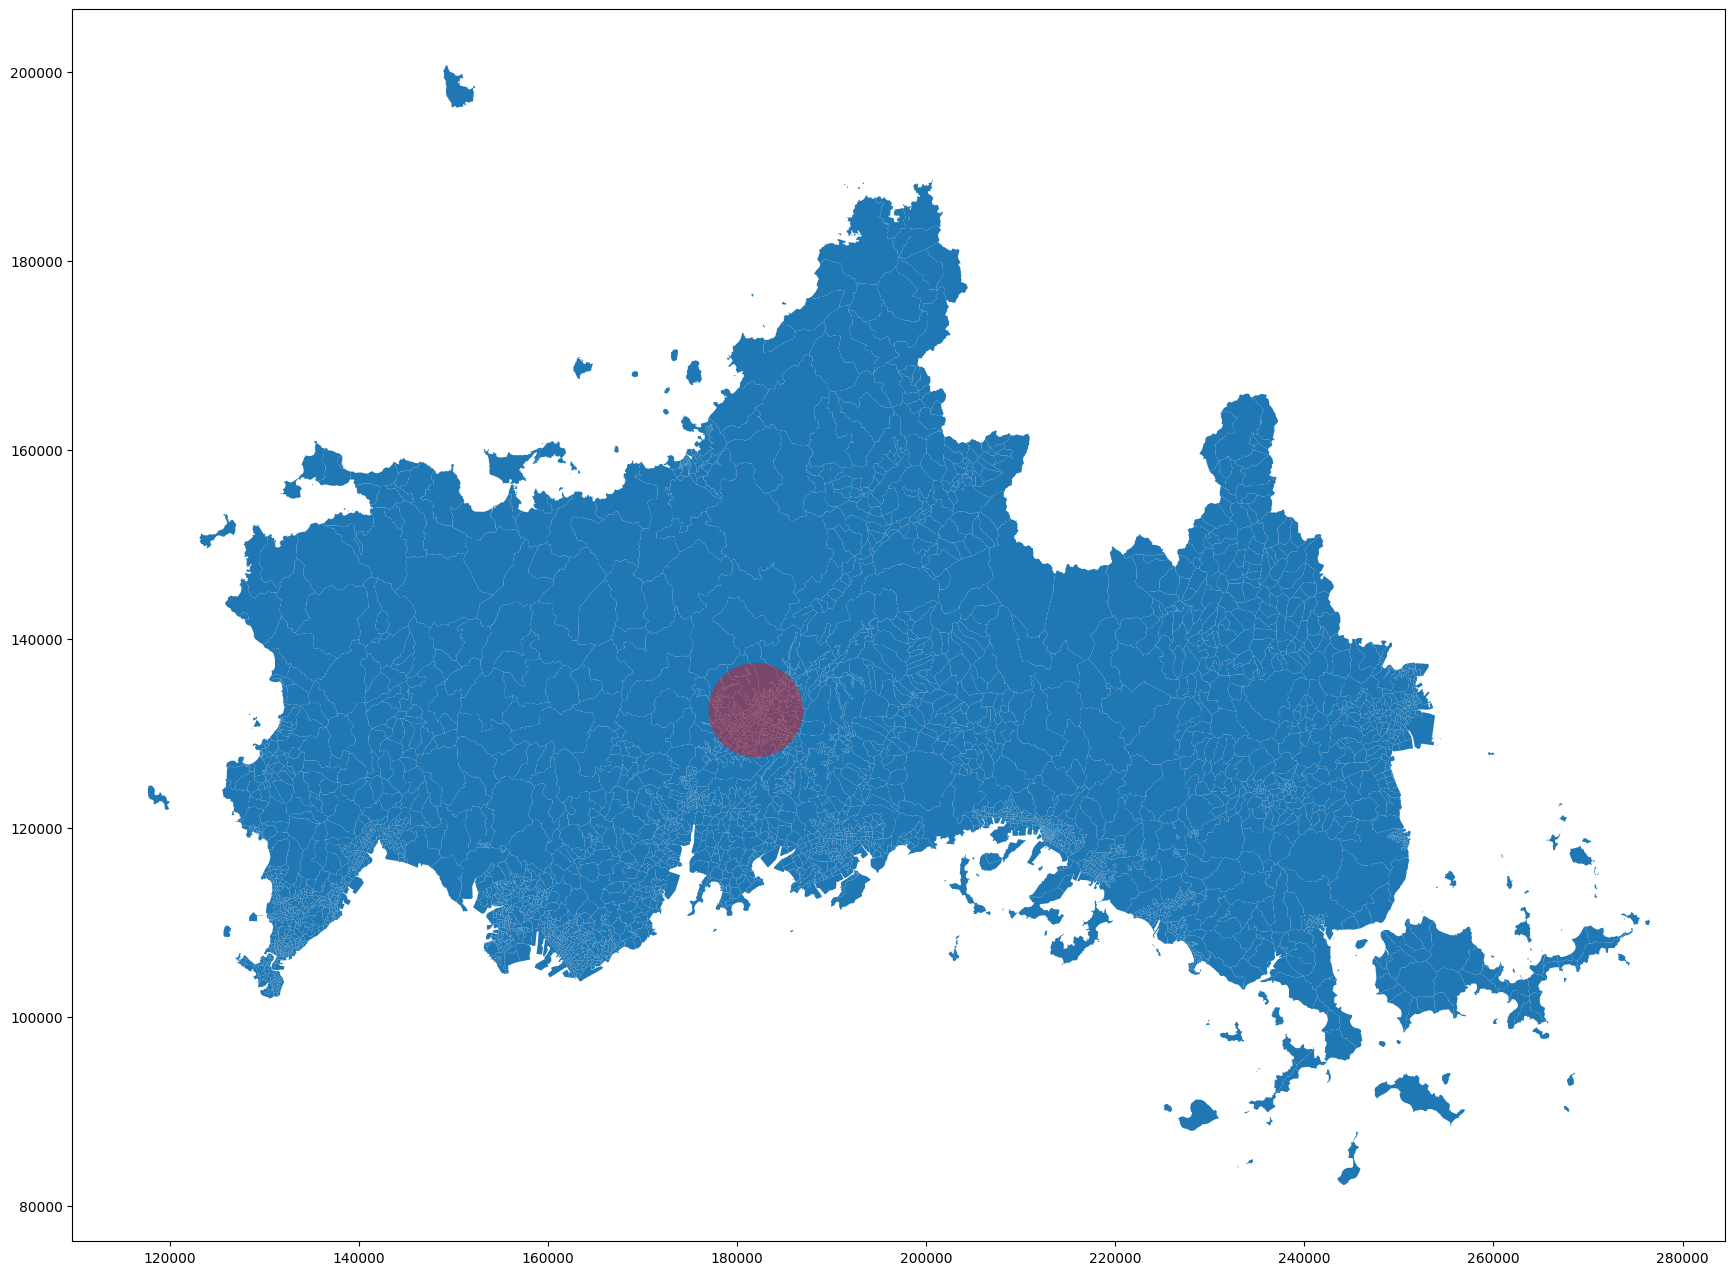

In [8]:
# 店舗の定義
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# 地理情報データの読み込み
yamaguchi = gpd.read_file(r'/content/drive/My Drive/BASE/GeoData/e-stat/Yamaguchi/r2ka35.shp')
yamaguchi = yamaguchi[yamaguchi['HCODE'] != 8154] # 水面調査区の除去

# 市名(CITY_NAME)，町丁・字等名称(S_NAME)，人口(JINKO)，geometry のみを抽出
yamaguchi = yamaguchi[['CITY_NAME', 'S_NAME', 'JINKO', 'geometry']]

# 投影座標系の変換（平面直角座標系への変換）
projected_yamaguchi = yamaguchi.to_crs('EPSG:2443', inplace=False)

# 山口市中心部(東経 131.473843度, 北緯 34.178295度)に仮想店舗を設置する
store = gpd.GeoDataFrame([['storeA', Point(131.473843, 34.178295)]],
                         columns=['name', 'geometry'],
                         crs='EPSG:4612')

#  仮想店舗を平面直角座標系へ変換した上で，半径 5[km] の商圏を設定
market_area = store.to_crs('EPSG:2443', inplace=False)
buffer_size = 5000 # 5000[m] = 5[km]
market_area['geometry'] = market_area.buffer(buffer_size) # 半径 5km (5000m) のポリゴンを生成

# 可視化
fig, ax = plt.subplots(1, figsize=(32, 16))
projected_yamaguchi.plot(ax=ax)
market_area.plot(ax=ax, color="red", alpha=0.4)

#### 商圏内の人口を求める
平面直角座標系（メートル単位）で表現された「山口県の地理情報・人口情報 (変数 `projected_yamaguchi`)」と「商圏情報（変数 `market_area`)」を空間結合することで，商圏内の人口を求める。

In [9]:
# 山口の地理情報と商圏を空間的に結合(spatial join)する
joined = gpd.sjoin(projected_yamaguchi, market_area, predicate='within')

変数 `projected_yamaguchi` (山口県の地理情報データ)と変数 `market_area` (仮想店舗の商圏）を空間結合すると，山口市 木町／香山町／水の上町／金古曽町／石観音町などが商圏に含まれることが分かる。

In [10]:
# (参考) 空間結合されたデータの中身を確認
joined.head()

,CITY_NAME,S_NAME,JINKO,geometry,index_right,name
1237,山口市,木町,261,"POLYGON ((181926.524 134064.778, 181929.076 13...",0,storeA
1238,山口市,香山町,233,"POLYGON ((181921.696 133782.263, 181917.105 13...",0,storeA
1239,山口市,水の上町,159,"POLYGON ((181854.023 133476.870, 181859.060 13...",0,storeA
1240,山口市,金古曽町,382,"POLYGON ((183062.026 133133.189, 182961.612 13...",0,storeA
1241,山口市,石観音町,150,"POLYGON ((182828.832 132955.386, 182770.076 13...",0,storeA


In [11]:
# (参考) 商圏内に町丁・字等名称(S_NAME)が何件含まれるか，見ておくと 258件のようだ
len(joined)

258

<Axes: >

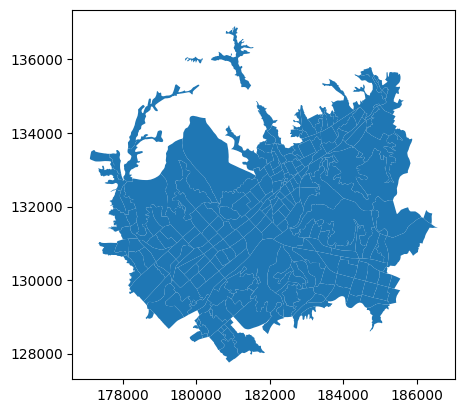

In [12]:
# (参考) 空間結合されたデータの可視化
joined.plot()

最後に `groupby()`メソッドを用いて，商圏内の総人口を求める。

In [13]:
# 商圏人口の算出
for name, group in joined.groupby('name'):
    total_pop = group['JINKO'].sum()
    print("{} の商圏人口：{}人".format(name, total_pop))

storeA の商圏人口：98597人


### ステップ２：現実の店舗配置による商圏人口の算出
山口県内で展開しているスーパー・チェーン「まるき」（株式会社 丸喜）を取り上げる。

(注意) 以下のコードでは，店舗を表す変数名が stores へ，また商圏を表す変数名が market_ares へと複数形に変更されている点に注意！！

In [31]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# 地理情報データの読み込み
yamaguchi = gpd.read_file(r'/content/drive/My Drive/BASE/GeoData/e-stat/Yamaguchi/r2ka35.shp')
yamaguchi = yamaguchi[yamaguchi['HCODE'] != 8154] # 水面調査区の除去

# 市名(CITY_NAME)，町丁・字等名称(S_NAME)，人口(JINKO)，geometry のみを抽出
yamaguchi = yamaguchi[['CITY_NAME', 'S_NAME', 'JINKO', 'geometry']]

# 投影座標系の変換（平面直角座標系への変換）
projected_yamaguchi = yamaguchi.to_crs('EPSG:2443', inplace=False)

# まるき店舗データの読み込み
maruki = pd.read_excel('/content/drive/My Drive/BASE/GeoData/maruki.xlsx')

# 店舗の定義
# [[店舗名A, Point(経度A,緯度A)], [店舗名B, Point(経度B,緯度B)], [店舗名C, Point(経度C,緯度C)]] の形のリストを作る
number_of_store = len(maruki)
store_list = list()
for idx in range(number_of_store):
    data = maruki.iloc[idx]
    store_list.append([data['店舗名'], Point(data['経度'], data['緯度'])])

# リストを GeoDataFrame へ変換
stores = gpd.GeoDataFrame(store_list,
                          columns=['name', 'geometry'], crs='EPSG:4612')

# 店舗位置を投影座標系へ変換した後，各店舗に半径 3km の商圏を設定
market_areas = stores.to_crs('EPSG:2443', inplace=False) # 投影座標系の変換

buffer_size = 3000 # 3000[m] = 3[km]
market_areas['geometry'] = market_areas.buffer(buffer_size) # 半径 buffer_size のポリゴンを生成

# 山口の地理情報と商圏を空間的に結合(spatial join)する
joined = gpd.sjoin(projected_yamaguchi, market_areas, predicate='within')


In [32]:
# (参考)空間結合の結果である変数 joined の冒頭を覗き見る
joined.head()

,CITY_NAME,S_NAME,JINKO,geometry,index_right,name
4,下関市,本町三丁目,188,"POLYGON ((133817.329 108365.683, 133824.244 10...",24,まるき武久店
13,下関市,貴船町一丁目,610,"POLYGON ((133379.746 108006.861, 133383.787 10...",24,まるき武久店
14,下関市,貴船町二丁目,444,"POLYGON ((133478.318 108309.589, 133479.534 10...",24,まるき武久店
15,下関市,貴船町三丁目,852,"POLYGON ((133562.051 108471.235, 133572.710 10...",24,まるき武久店
16,下関市,貴船町四丁目,937,"POLYGON ((133195.552 108683.803, 133226.869 10...",24,まるき武久店


In [33]:
# (参考)空間結合の結果である変数 joined の末尾を覗き見る
joined.tail()

,CITY_NAME,S_NAME,JINKO,geometry,index_right,name
4148,山陽小野田市,大字厚狭,0,"POLYGON ((153669.339 118457.692, 153674.039 11...",16,ウェスタまるき厚狭店
4151,山陽小野田市,大字山川,0,"POLYGON ((153261.191 118002.749, 153348.373 11...",16,ウェスタまるき厚狭店
4157,山陽小野田市,厚狭,289,"POLYGON ((153931.013 118281.270, 153903.071 11...",16,ウェスタまるき厚狭店
4158,山陽小野田市,桜一丁目,246,"POLYGON ((153018.914 118164.395, 153119.241 11...",16,ウェスタまるき厚狭店
4159,山陽小野田市,桜二丁目,303,"POLYGON ((153018.914 118164.395, 153018.014 11...",16,ウェスタまるき厚狭店


<Axes: >

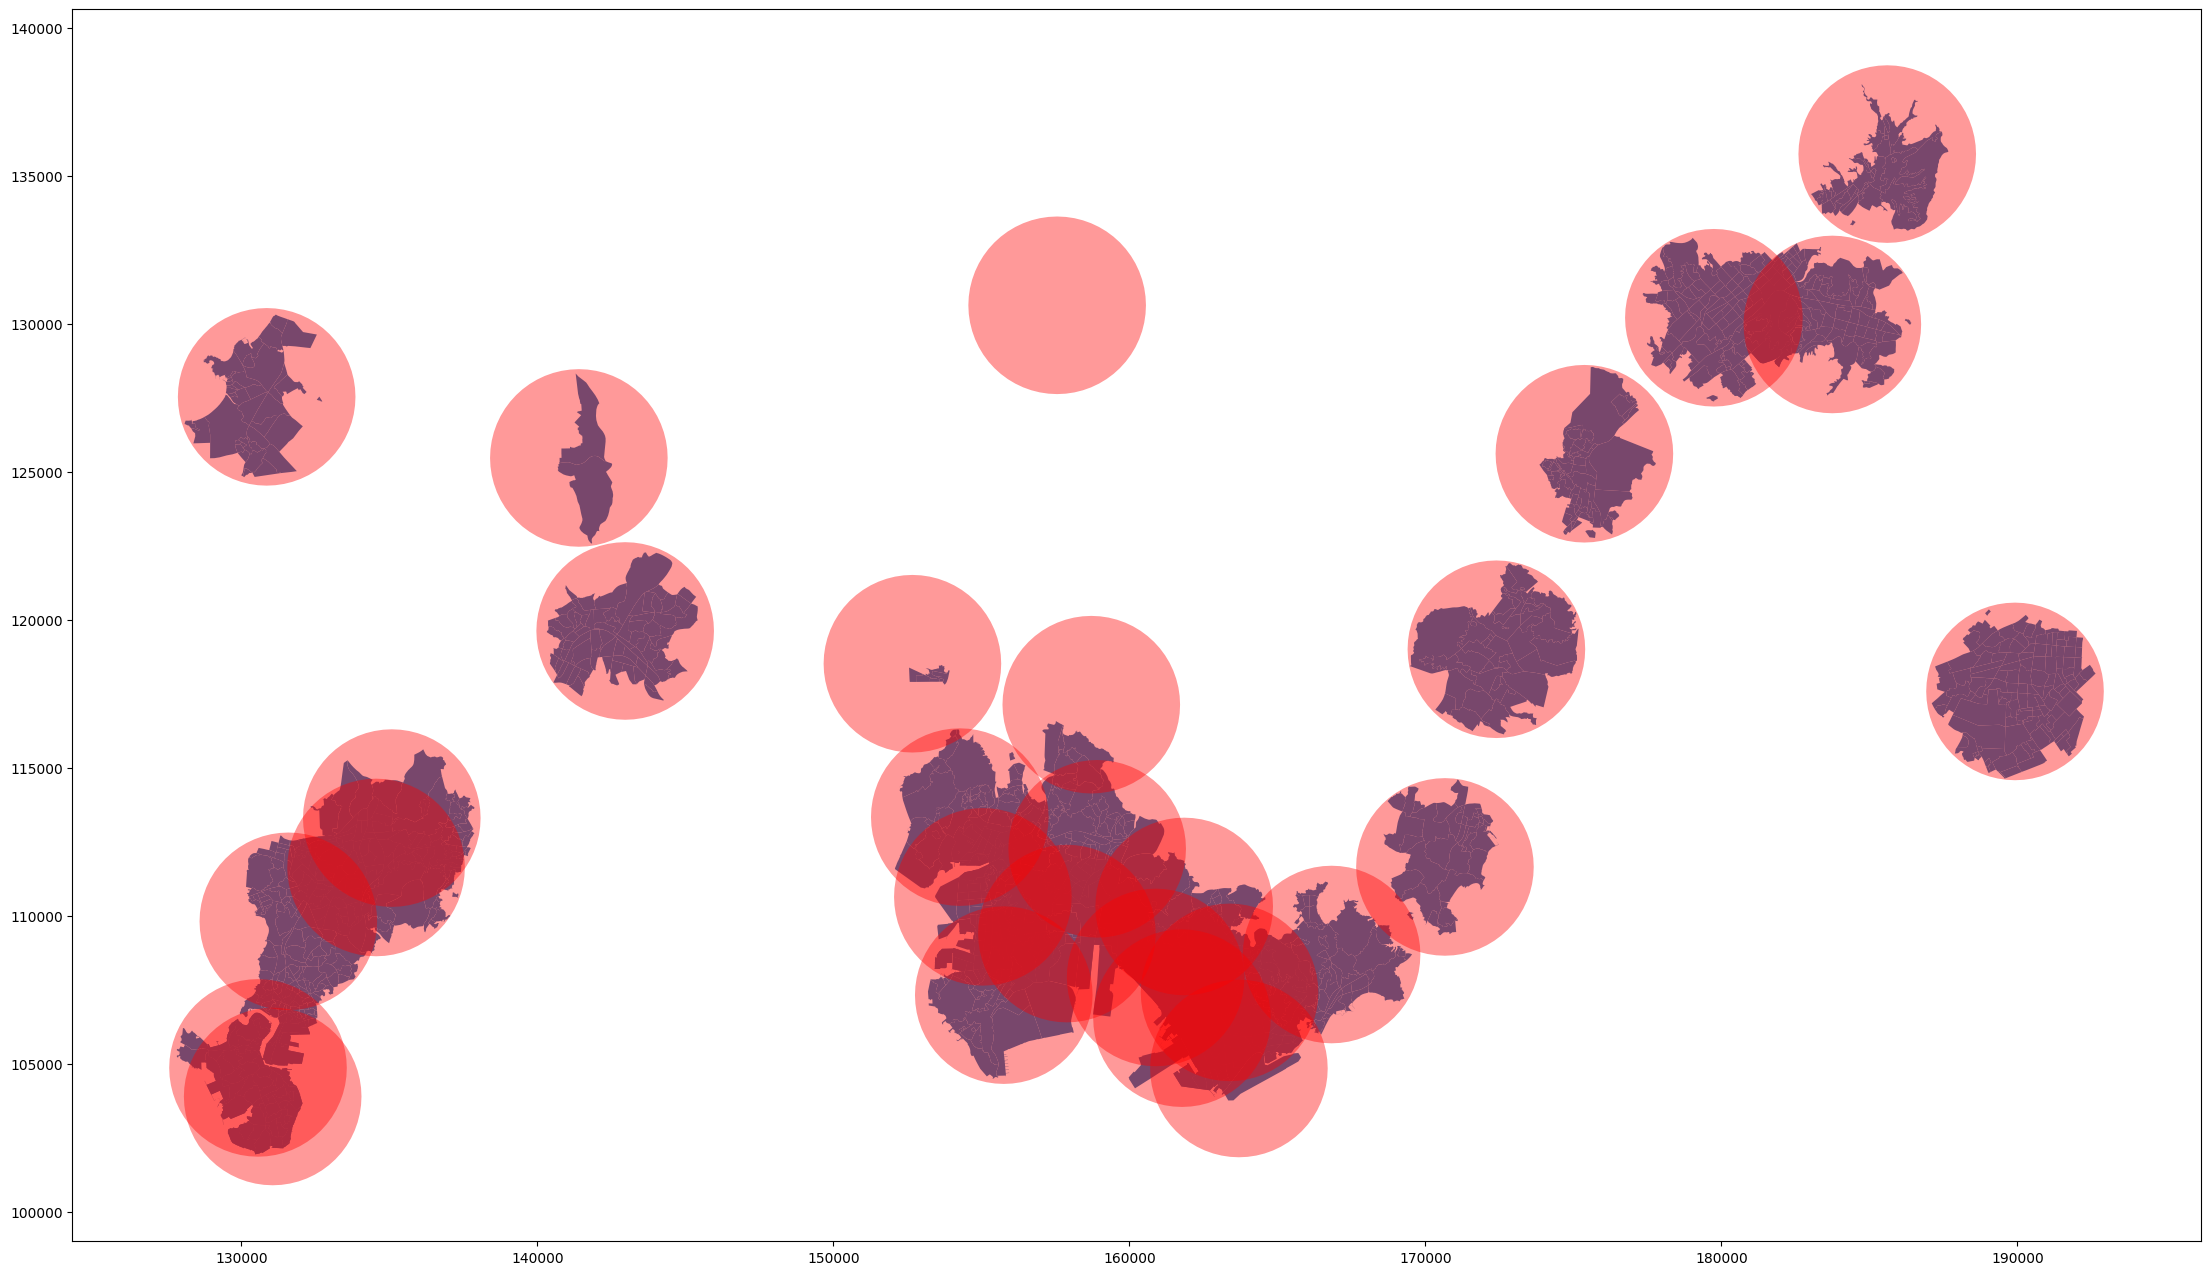

In [35]:
# (参考)商圏に含まれる地域を可視化
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(32, 16))
joined.plot(ax=ax)
market_areas.plot(ax=ax, color='red', alpha=0.4)

最後に，各店舗の商圏人口を算出する。

In [36]:
# 各店舗の商圏人口の算出
print("=== 商圏人口の一覧 ===")
for name, group in joined.groupby('name'):
    total_pop = group['JINKO'].sum()
    print("{}：{}人".format(name, total_pop))

=== 商圏人口の一覧 ===
まるき小野田大学通り店：20765人
まるき山口嘉川店：6840人
まるき常盤通り店：54348人
まるき彦島店：33040人
まるき武久店：72245人
まるき角倉店：23722人
ウェスタまるき下関一の宮店：53862人
ウェスタまるき下関小月店：11786人
ウェスタまるき下関形山店：39856人
ウェスタまるき中川店：27470人
ウェスタまるき厚狭店：838人
ウェスタまるき小松原通り店：45782人
ウェスタまるき小羽山店：35537人
ウェスタまるき小郡店：17488人
ウェスタまるき山口大内店：32076人
ウェスタまるき山口宮野店：10195人
ウェスタまるき山口湯田店：57995人
ウェスタまるき工学部通り店：67108人
ウェスタまるき東岐波店：11203人
ウェスタまるき楠店：1052人
ウェスタまるき神田店：18023人
ウェスタまるき空港通り店：34038人
ウェスタまるき菊川店：3051人
ウェスタまるき華城店：57827人
ウェスタまるき西割店：37857人
ウェスタまるき西宇部店：29995人
ウェスタまるき西岐波店：24549人
ウェスタまるき豊浦店：7750人
